# Анализ текстов на токсичность

**Цели исследования:**

Для предприятия «Викишоп» с целью автоматической классификации комментариев на позитивные и негативные обучить ML модель по набору размеченных данных в виде корпуса текстов, классифицированных на токсичные и нетоксичные.
Построить модель со значением метрики качества F1 не меньше 0.75

**Ход исследования:**
- Подготовка данных:
    - Загрузка данных корпуса текстов и необходимых библиотек для работы с ним
    - Анализ и очистка данных
    - Лемматизация и векторизация данных
- Подготовка моделей машинного обучения:
    - Обучение нескольких моделей методом кросс-валидации
    - Выбор наилучшей модели по F1 мере
- Тестирование выбранной модели
- Итоговый вывод

**Результаты исследования:**

- Текст был очищен от несловарных символов, затем лемматизирован и векторизован
- В процессе обучения моделей машинного обучения для некоторых из них были получены удовлетворительные характеристики по F1 мере.
- В ходе тестирования лучшей отобранной модели подтвердилось качество обученной модели на тестовой выборке, модель рекомендована заказчику

**Описание данных:**

Данные находятся в файле `toxic_comments.csv`. Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

## Подготовка данных

### Загрузка библиотек 

In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.feature_selection import RFE, RFECV

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet

from scipy import stats, sparse


### Загрузка и знакомство с данными

In [16]:
comms = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/toxic_comments.csv')

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/panther/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/panther/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/panther/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [17]:
comms.head(20)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Удаляю лишний столбец с индексами:

In [18]:
comms = comms.drop('Unnamed: 0', axis=1)

In [19]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Для экономии:

In [20]:
# хотелось бы заменить на bool, но тогда начинает глючить CatBoost

comms['toxic'] = comms['toxic'].astype('int8')

Распределение целевого признака:

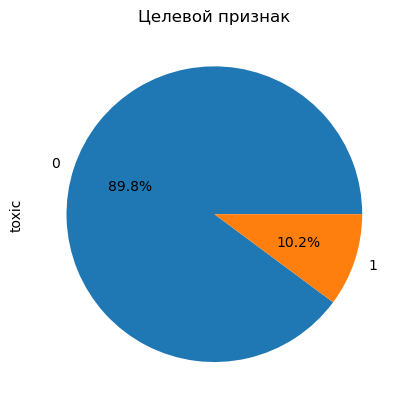

In [21]:
comms['toxic'].value_counts().plot.pie(autopct='%1.1f%%', title='Целевой признак');

Заметен дисбаланс классов, при обучении моделей в дальнейшем будет использован встроенный метод балансировки (как правило, задается параметром `class_weight='balanced'`)

Очищаю текст от посторонних символов:

In [22]:
# Фильтрую небуквенные символы
comms['text'] = comms['text'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x))

# Фильтрую одинаковые символы, стоящие в группах по 3 и более
comms['text'] = comms['text'].apply(lambda x: re.sub(r'(.)\1{2,}', ' ', x))

In [23]:
comms.head(20)

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D'aww He matches this background colour I'm s...,0
2,Hey man I'm really not trying to edit war It...,0
3,More I can't make any real suggestions on im...,0
4,You sir are my hero Any chance you remember...,0
5,Congratulations from me as well use the tool...,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Провожу лемматизацию текста:

In [24]:
def lemmatize_text(text):
    '''Токенизириует и лемматизирует текст сообразно части речи, возвращает также текст из объединенных лемм'''
    word_classes = {'J': 'a', 'N': 'n', 'V': 'v', 'R': 'r'}
    lemmas = []
    for word, tag in nltk.pos_tag(tok.tokenize(text)):
        if word.isupper():
            lemmas.append(lem.lemmatize(word.lower(), word_classes.get(tag[0], 'n')).upper())
        else:
            lemmas.append(lem.lemmatize(word.lower(), word_classes.get(tag[0], 'n')))
    return ' '.join(lemmas)

In [25]:
%%time

lem = WordNetLemmatizer()
tok = WhitespaceTokenizer()

comms['lemmatized'] = comms['text'].apply(lemmatize_text)

CPU times: user 6min 8s, sys: 1.28 s, total: 6min 9s
Wall time: 6min 10s


In [26]:
comms.head(20)

,text,toxic,lemmatized
0,Explanation Why the edits made under my userna...,0,explanation why the edits make under my userna...
1,D'aww He matches this background colour I'm s...,0,d'aww he match this background colour i'm seem...
2,Hey man I'm really not trying to edit war It...,0,hey man i'm really not try to edit war it's ju...
3,More I can't make any real suggestions on im...,0,more I can't make any real suggestion on impro...
4,You sir are my hero Any chance you remember...,0,you sir be my hero any chance you remember wha...
5,Congratulations from me as well use the tool...,0,congratulation from me a well use the tool wel...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word 'nonsense' be offensive to y...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


Проверка пустых строк:

In [27]:
comms[comms['lemmatized'] == ''].shape[0]

12

Удаляю пустые строки:

In [28]:
comms = comms[comms['lemmatized'] != '']
comms[comms['lemmatized'] == ''].shape[0]

0

Проверка дубликатов строк:

In [29]:
comms.duplicated().sum()

696

Удаляю дубликаты:

In [30]:
comms = comms.drop_duplicates()
comms.duplicated().sum()

0

### Разделение выборок, отделение целевого признака, а также добавление новых признаков

In [31]:
stop_words = stopwords.words('english')

In [40]:
def get_freq_words(data, n):
    '''Возвращает n самых часто встречаемых слов/лемм в корпусе data'''
    counter = CountVectorizer(max_features=n, stop_words=stop_words)
    counter.fit_transform(data)
    return set(counter.get_feature_names_out())
    
def toxic_in_string(string, words):
    '''Возвращает число вхождений "плохих слов" из списка filtered_tw в строку string'''
    return sum(1 for lem in string.lower().split() if lem in words)
    
def upper_words_percent(text):
    '''Возвращает процент слов в text, полностью написанных заглавными буквами'''
    return round(sum(1 for lem in text.split() if str.isupper(lem)) / len(text.split()) * 100)

def vectorize_features(f_train, f_test, st_words, min_df=3, ngram=(1, 1)):
    '''Возвращает признаки в векторизованном виде'''
    vectorizer = TfidfVectorizer(stop_words=st_words, sublinear_tf=True, min_df=min_df, ngram_range=ngram)
    vectorized = vectorizer.fit(f_train['lemmatized'])

    f_train = vectorizer.transform(f_train['lemmatized'])
    f_test = vectorizer.transform(f_test['lemmatized'])
    return f_train, f_test

def split_data(corpus, add_mean_u=True, add_count_toxic=True, vectorize=False, elimin_f=False,
               f_merge=False, random_state=42):
    '''В зависимости от условий делит данные с добавлением признаков, векторизацией, удалением ненужных '''
    
    if add_mean_u: # создаст новый признак 'mean_u_case', считающий среднее значение заглавных слов в тексте
        corpus['mean_u_case'] = corpus['text'].apply(lambda x : upper_words_percent(x)).astype('int8')
    
    corpus_train, corpus_test = train_test_split(corpus, test_size=0.1, random_state=random_state)        
    
    if add_count_toxic: # создаст новый признак 'toxic_counted', считающий количество "плохих" слов в тексте
        toxic_words = get_freq_words(corpus_train.loc[corpus_train['toxic'] == True, 'lemmatized'], 10000)
        regular_words = get_freq_words(corpus_train.loc[corpus_train['toxic'] == False, 'lemmatized'], 20000)
        filtered_tw = toxic_words - toxic_words.intersection(regular_words)
        
        corpus_train['toxic_counted'] = corpus_train['lemmatized'].apply(
                                                    lambda x: toxic_in_string(x, filtered_tw)).astype('int16')
        corpus_test['toxic_counted'] = corpus_test['lemmatized'].apply(
                                                    lambda x: toxic_in_string(x, filtered_tw)).astype('int16')
    
    
    features_train = corpus_train.drop(['text', 'toxic'], axis=1)
    target_train = corpus_train['toxic']

    features_test = corpus_test.drop(['text', 'toxic'], axis=1)
    target_test = corpus_test['toxic']
    
     
    if vectorize:
        features_train, features_test = vectorize_features(features_train, features_test,
                                                                              st_words=stop_words)
        
        if elimin_f: # удаление признаков, которые не вносят существенного вклада в значение метрики f1
            selected_features = []
            estimators = [LogisticRegression, SGDClassifier]
            print(f'\nРазмерность признакового пространства train до удаления признаков: {features_train.shape}')

            for model in estimators:
                print('\nНачат процесс рекурсивного удаления незначимых признаков. Ждите.\n')
                estimator = model(random_state=random_state)
                selector = RFE(estimator, step=100, verbose=1, n_features_to_select=0.05)
                selector = selector.fit(features_train, target_train)
                selected_features.append(selector.support_)
                print(f'Число признаков: {selector.n_features_}')
                
            # выбираю только те признаки, которые признаны незначимыми (False) всеми моделями: 
            selected_features = pd.DataFrame(selected_features).any().values
            features_train = features_train[:, selected_features]
            features_test = features_test[:, selected_features]
            print(f'\nРазмерность признакового пространства train после удаления: {features_train.shape}\n')
            
        if f_merge: # добавление новых признаков к векторизованным данным корпуса
            features_train = sparse.hstack([features_train,
                                      corpus_train[['mean_u_case', 'toxic_counted']].values], format='csr')

            features_test = sparse.hstack([features_test,
                                      corpus_test[['mean_u_case', 'toxic_counted']].values], format='csr')
           
    return features_train, features_test, target_train, target_test

In [38]:
features_train, features_test, target_train, target_test = split_data(comms, vectorize=True,
                                                                      f_merge=True, elimin_f=True)

Размерность полученных выборок:

In [268]:
for i in features_train, features_test, target_train, target_test:
    print(i.shape)

(142725, 2680)
(15859, 2680)
(142725,)
(15859,)


### Выводы, подготовка данных
- Файл `toxic_comments.csv` был загружен в датафрейм `comms`, также с помощью менеджера загрузки модуля `nltk` были догружены базы `stopwords`, `omw-1.4`, `averaged_perceptron_tagger`. Файл содержит 159292 строк с текстами и метками, определяющими класс "токсичности" (0 - нетоксичный, 1 - токсичный)
- В ходе знакомства с данными была выявлена проблема засоренности корпуса текстов нетипичными символами. Данные были очищены регулярными выражениями.
- Обнаружен дисбаланс классов целевого признака, который будет учтен при обучении моделей машинного обучения.

- При подготовке данных проведена лемматизация тектов, результат сохранен в колонке `lemmatized`.
- Cформулированы и добавлены новые признаки - количество "плохих" слов в отдельном тексте (колонка `toxic_counted`) и среднее количество слов в тексте, полностью написанных заглавными буквами (колонка `mean_u_case`).
- Корпус текста векторизован с помощью `TfidfVectorizer()`, применяющим `TF-IDF` метод ранжирования, после чего для уменьшения размеров и облегчения обучения корпус был проведен через рекурсивное удаление признаков (методом `RFECV`)

## Обучение моделей

In [269]:

def finetune(model_name, parameters, features, target, verbose=3, jobs=-1, cv=StratifiedKFold(5), **kwargs):
    '''Фукнция подбора гиперпараметров
    На вход принимает класс модели, решетку гиперпараметров для поиска, признаки и целевой признак
    Возвращает лучшую из обученных моделей, её гиперпараметры и её луший результат по метрике F1
    '''
    cv = GridSearchCV(model_name(**kwargs), param_grid=parameters, scoring='f1',
                            cv=cv, verbose=verbose, n_jobs=jobs)
    cv.fit(features, target)  
    
    return cv.best_estimator_, cv.best_params_, cv.best_score_

def print_cv_results(params, metric):
    '''Выводит результаты кросс-валидации на экран'''
    print()
    print(f'Лучшие параметры модели: {params}')
    print(f'(train, CV) лучшее F1: {metric:.4f}')
    print()

In [270]:
def roc_auc(model, x_train, x_test, y_train, y_test, plot=False, scores=True):
    '''Выводит характеристики площади под ROC кривой, а также строит её график'''
    p_pred_train = model.predict_proba(x_train)[:, 1]
    p_pred_test = model.predict_proba(x_test)[:, 1]
    
    roc_train = roc_auc_score(y_train, p_pred_train)
    roc_test = roc_auc_score(y_test, p_pred_test)
    
    if plot:
        plt.figure(figsize=(8, 7))

        plt.plot(*roc_curve(y_train, p_pred_train)[:2], label=f'(train) AUC: {roc_train:.4f}')
        plt.plot(*roc_curve(y_test, p_pred_test)[:2], label=f'(test) AUC: {roc_test:.4f}')

        plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
        plt.title(f'ROC-AUC for {type(model).__name__}')
        plt.plot([0, 1]); plt.ylim([-0.01, 1.01]); plt.xlim([-0.01, 1.01]); plt.legend(); plt.show()
    
    if scores:
        return roc_train, roc_test

### Логистическая регрессия

In [281]:
%%time

params = {
    'C': [105],
    'penalty': ['l2'],
    'max_iter': [157, 159],
#     'class_weight': [None, 'balanced']
}
lr_cv_model, lr_cv_params, lr_cv_f1 = finetune(LogisticRegression, params,
                                    features_train, target_train, random_state=42)
print_cv_results(lr_cv_params, lr_cv_f1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re


Лучшие параметры модели: {'C': 105, 'max_iter': 159, 'penalty': 'l2'}
(train, CV) лучшее F1: 0.8071

CPU times: user 2.16 s, sys: 235 ms, total: 2.39 s
Wall time: 33.1 s


/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...C=103, max_iter=157, penalty=l2;, score=0.806 total time=   3.0s
[CV 2/5] END ...C=103, max_iter=159, penalty=l2;, score=0.792 total time=   3.1s
[CV 2/5] END ...C=104, max_iter=157, penalty=l2;, score=0.799 total time=   3.0s
[CV 1/5] END ...C=104, max_iter=159, penalty=l2;, score=0.799 total time=   2.9s
[CV 4/5] END ...C=104, max_iter=159, penalty=l2;, score=0.804 total time=   3.0s
[CV 4/5] END ...C=105, max_iter=157, penalty=l2;, score=0.806 total time=   3.2s
[CV 3/5] END ...C=105, max_iter=159, penalty=l2;, score=0.809 total time=   2.8s
[CV 2/5] END ...C=106, max_iter=157, penalty=l2;, score=0.798 total time=   2.8s
[CV 1/5] END ...C=106, max_iter=159, penalty=l2;, score=0.794 total time=   3.8s
[CV 3/5] END ...C=103, max_iter=157, penalty=l2;, score=0.810 total time=   2.8s
[CV 1/5] END ...C=103, max_iter=159, penalty=l2;, score=0.797 total time=   3.3s
[CV 1/5] END ...C=104, max_iter=157, penalty=l2;, score=0.800 total time=   2.5s
[CV 4/5] END ...C=104, max_i

### SGD-классификатор

In [272]:
%%time

params = {'alpha': [0.0000015],
          'eta0': [0.004],
          'learning_rate': ['adaptive'],
          'loss': ['modified_huber'],
          'max_iter': [80],
          'n_iter_no_change': [13],
#           'class_weight': [None, 'balanced']
}
sgd_cv_model, sgd_cv_params, sgd_cv_f1 = finetune(SGDClassifier, params,
                                    features_train, target_train, random_state=42)
print_cv_results(sgd_cv_params, sgd_cv_f1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/panther/anaconda3/


Лучшие параметры модели: {'alpha': 1.5e-06, 'eta0': 0.004, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'max_iter': 80, 'n_iter_no_change': 13}
(train, CV) лучшее F1: 0.7631

CPU times: user 2.03 s, sys: 20.7 ms, total: 2.05 s
Wall time: 7.59 s


/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### LightGBM-классификатор

In [219]:
%%time

params = {
        'learning_rate': [0.12],
          'num_leaves': [150],
          'max_bin': [20]
}

lgbm_cv_model, lgbm_cv_params, lgbm_cv_f1 = finetune(LGBMClassifier, params, features_train,
                                               target_train, random_state=42)
print_cv_results(lgbm_cv_params, lgbm_cv_f1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..C=507, max_iter=1444, penalty=l2;, score=0.792 total time=  25.4s
[CV 1/3] END learning_rate=0.12, max_bin=20, num_leaves=150;, score=0.781 total time=  57.2s

Лучшие параметры модели: {'learning_rate': 0.12, 'max_bin': 20, 'num_leaves': 150}
(train, CV) лучшее F1: 0.7870

CPU times: user 1min 47s, sys: 675 ms, total: 1min 48s
Wall time: 1min 31s


### CatBoost-классификатор

In [211]:
%%time

params = {
        'learning_rate': [0.7, 0.8, 0.9],
        'iterations': [300, 400],
        'boosting_type': ['Plain'],
        'bootstrap_type': ['Bernoulli'],
        'subsample': [0.5],
        'rsm': [0.6],
}

cb_cv_model, cb_cv_params, cb_cv_f1 = finetune(CatBoostClassifier, params, features_train,
                                               target_train, random_state=42, eval_metric='F1')
print_cv_results(cb_cv_params, cb_cv_f1)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=70, n_iter_no_change=13;, score=0.789 total time=   2.2s
[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=70, n_iter_no_change=13;, score=0.741 total time=   2.2s
[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=80, n_iter_no_change=13;, score=0.797 total time=   3.1s
[CV 1/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=75, n_iter_no_change=13;, score=0.737 total time=   2.6s
[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=80, n_iter_no_change=13;, score=0.797 total time=   2.7s
[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=85, n_iter_no_change=13;, score=0.760 total time=   1.8s
[CV 1/3] END alpha=1.5e-06, eta0=0

[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=60, n_iter_no_change=13;, score=0.776 total time=   2.4s
[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=80, n_iter_no_change=13;, score=0.797 total time=   2.9s
[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=90, n_iter_no_change=13;, score=0.736 total time=   3.2s
[CV 1/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=80, n_iter_no_change=13;, score=0.786 total time=   2.9s
[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=85, n_iter_no_change=13;, score=0.788 total time=   3.4s
[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=79, n_iter_no_change=13;, score=0.774 total time=   3.2s
[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=

[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=60, n_iter_no_change=13;, score=0.790 total time=   2.1s
[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=70, n_iter_no_change=13;, score=0.795 total time=   2.7s
[CV 1/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=90, n_iter_no_change=13;, score=0.712 total time=   3.2s
[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=75, n_iter_no_change=13;, score=0.700 total time=   2.6s
[CV 3/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=80, n_iter_no_change=13;, score=0.797 total time=   3.3s
[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=79, n_iter_no_change=13;, score=0.768 total time=   4.0s
[CV 2/3] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=

119:	learn: 0.8224564	total: 1m 35s	remaining: 2m 23s
120:	learn: 0.8227432	total: 1m 36s	remaining: 2m 22s
121:	learn: 0.8232097	total: 1m 36s	remaining: 2m 21s
122:	learn: 0.8236958	total: 1m 37s	remaining: 2m 20s
123:	learn: 0.8242150	total: 1m 38s	remaining: 2m 20s
124:	learn: 0.8250791	total: 1m 39s	remaining: 2m 19s
125:	learn: 0.8261140	total: 1m 40s	remaining: 2m 18s
126:	learn: 0.8265387	total: 1m 41s	remaining: 2m 17s
127:	learn: 0.8266952	total: 1m 41s	remaining: 2m 16s
128:	learn: 0.8274189	total: 1m 42s	remaining: 2m 15s
129:	learn: 0.8278194	total: 1m 43s	remaining: 2m 15s
130:	learn: 0.8279630	total: 1m 44s	remaining: 2m 14s
131:	learn: 0.8281804	total: 1m 44s	remaining: 2m 12s
132:	learn: 0.8284443	total: 1m 45s	remaining: 2m 12s
133:	learn: 0.8292820	total: 1m 46s	remaining: 2m 11s
134:	learn: 0.8294713	total: 1m 46s	remaining: 2m 10s
135:	learn: 0.8298088	total: 1m 48s	remaining: 2m 10s
136:	learn: 0.8300720	total: 1m 48s	remaining: 2m 9s
137:	learn: 0.8301484	total: 

266:	learn: 0.8626871	total: 3m 34s	remaining: 26.5s
267:	learn: 0.8626247	total: 3m 35s	remaining: 25.7s
268:	learn: 0.8628763	total: 3m 36s	remaining: 24.9s
269:	learn: 0.8633149	total: 3m 37s	remaining: 24.2s
270:	learn: 0.8632525	total: 3m 38s	remaining: 23.4s
271:	learn: 0.8637211	total: 3m 39s	remaining: 22.6s
272:	learn: 0.8637535	total: 3m 40s	remaining: 21.8s
273:	learn: 0.8639527	total: 3m 42s	remaining: 21.1s
274:	learn: 0.8638431	total: 3m 42s	remaining: 20.3s
275:	learn: 0.8637335	total: 3m 43s	remaining: 19.4s
276:	learn: 0.8636413	total: 3m 44s	remaining: 18.6s
277:	learn: 0.8637808	total: 3m 45s	remaining: 17.8s
278:	learn: 0.8639851	total: 3m 46s	remaining: 17s
279:	learn: 0.8643557	total: 3m 47s	remaining: 16.2s
280:	learn: 0.8644003	total: 3m 47s	remaining: 15.4s
281:	learn: 0.8643233	total: 3m 48s	remaining: 14.6s
282:	learn: 0.8642611	total: 3m 49s	remaining: 13.8s
283:	learn: 0.8643854	total: 3m 50s	remaining: 13s
284:	learn: 0.8644179	total: 3m 50s	remaining: 12.

270:	learn: 0.8556468	total: 3m 37s	remaining: 23.3s
271:	learn: 0.8562455	total: 3m 38s	remaining: 22.5s
272:	learn: 0.8562455	total: 3m 39s	remaining: 21.7s
273:	learn: 0.8564504	total: 3m 41s	remaining: 21s
274:	learn: 0.8564975	total: 3m 42s	remaining: 20.2s
275:	learn: 0.8566865	total: 3m 43s	remaining: 19.4s
276:	learn: 0.8567809	total: 3m 44s	remaining: 18.6s
277:	learn: 0.8571901	total: 3m 45s	remaining: 17.9s
278:	learn: 0.8571901	total: 3m 46s	remaining: 17.1s
279:	learn: 0.8573631	total: 3m 47s	remaining: 16.2s
280:	learn: 0.8573946	total: 3m 48s	remaining: 15.4s
281:	learn: 0.8570957	total: 3m 48s	remaining: 14.6s
282:	learn: 0.8570642	total: 3m 50s	remaining: 13.8s
283:	learn: 0.8572215	total: 3m 50s	remaining: 13s
284:	learn: 0.8572687	total: 3m 51s	remaining: 12.2s
285:	learn: 0.8572687	total: 3m 52s	remaining: 11.4s
286:	learn: 0.8573631	total: 3m 53s	remaining: 10.6s
287:	learn: 0.8575517	total: 3m 53s	remaining: 9.74s
288:	learn: 0.8576463	total: 3m 54s	remaining: 8.9

120:	learn: 0.8294946	total: 1m 33s	remaining: 2m 17s
121:	learn: 0.8296255	total: 1m 34s	remaining: 2m 17s
122:	learn: 0.8306353	total: 1m 34s	remaining: 2m 16s
123:	learn: 0.8309702	total: 1m 35s	remaining: 2m 15s
124:	learn: 0.8311949	total: 1m 36s	remaining: 2m 14s
125:	learn: 0.8318920	total: 1m 36s	remaining: 2m 13s
126:	learn: 0.8323106	total: 1m 37s	remaining: 2m 12s
127:	learn: 0.8329244	total: 1m 37s	remaining: 2m 11s
128:	learn: 0.8335471	total: 1m 38s	remaining: 2m 11s
129:	learn: 0.8340302	total: 1m 39s	remaining: 2m 10s
130:	learn: 0.8344851	total: 1m 40s	remaining: 2m 9s
131:	learn: 0.8344851	total: 1m 41s	remaining: 2m 9s
132:	learn: 0.8346702	total: 1m 41s	remaining: 2m 7s
133:	learn: 0.8347071	total: 1m 42s	remaining: 2m 7s
134:	learn: 0.8347904	total: 1m 43s	remaining: 2m 6s
135:	learn: 0.8354022	total: 1m 44s	remaining: 2m 5s
136:	learn: 0.8354670	total: 1m 44s	remaining: 2m 4s
137:	learn: 0.8355966	total: 1m 45s	remaining: 2m 3s
138:	learn: 0.8361815	total: 1m 46s	

127:	learn: 0.8275361	total: 1m 36s	remaining: 2m 9s
128:	learn: 0.8282727	total: 1m 36s	remaining: 2m 8s
129:	learn: 0.8284308	total: 1m 37s	remaining: 2m 7s
130:	learn: 0.8286465	total: 1m 38s	remaining: 2m 7s
131:	learn: 0.8290856	total: 1m 39s	remaining: 2m 6s
132:	learn: 0.8291783	total: 1m 39s	remaining: 2m 5s
133:	learn: 0.8293473	total: 1m 40s	remaining: 2m 4s
134:	learn: 0.8296553	total: 1m 41s	remaining: 2m 3s
135:	learn: 0.8298871	total: 1m 42s	remaining: 2m 3s
136:	learn: 0.8303911	total: 1m 42s	remaining: 2m 2s
137:	learn: 0.8304649	total: 1m 43s	remaining: 2m 1s
138:	learn: 0.8319196	total: 1m 44s	remaining: 2m 1s
139:	learn: 0.8321616	total: 1m 45s	remaining: 2m
140:	learn: 0.8325434	total: 1m 46s	remaining: 1m 59s
141:	learn: 0.8328505	total: 1m 47s	remaining: 1m 59s
142:	learn: 0.8330825	total: 1m 47s	remaining: 1m 58s
143:	learn: 0.8334912	total: 1m 48s	remaining: 1m 57s
144:	learn: 0.8336211	total: 1m 49s	remaining: 1m 56s
145:	learn: 0.8337325	total: 1m 50s	remainin

281:	learn: 0.8604600	total: 3m 29s	remaining: 13.3s
282:	learn: 0.8603976	total: 3m 30s	remaining: 12.6s
283:	learn: 0.8602257	total: 3m 30s	remaining: 11.9s
284:	learn: 0.8602881	total: 3m 31s	remaining: 11.1s
285:	learn: 0.8605071	total: 3m 32s	remaining: 10.4s
286:	learn: 0.8603976	total: 3m 33s	remaining: 9.65s
287:	learn: 0.8607872	total: 3m 33s	remaining: 8.91s
288:	learn: 0.8610518	total: 3m 34s	remaining: 8.17s
289:	learn: 0.8611461	total: 3m 35s	remaining: 7.43s
290:	learn: 0.8609743	total: 3m 36s	remaining: 6.68s
291:	learn: 0.8617673	total: 3m 36s	remaining: 5.94s
292:	learn: 0.8617673	total: 3m 37s	remaining: 5.19s
293:	learn: 0.8618144	total: 3m 37s	remaining: 4.45s
294:	learn: 0.8622349	total: 3m 38s	remaining: 3.71s
295:	learn: 0.8623553	total: 3m 39s	remaining: 2.97s
296:	learn: 0.8623553	total: 3m 40s	remaining: 2.23s
297:	learn: 0.8625116	total: 3m 41s	remaining: 1.48s
298:	learn: 0.8624495	total: 3m 41s	remaining: 742ms
299:	learn: 0.8626038	total: 3m 42s	remaining:

278:	learn: 0.8668410	total: 3m 29s	remaining: 15.7s
279:	learn: 0.8668700	total: 3m 29s	remaining: 15s
280:	learn: 0.8682576	total: 3m 30s	remaining: 14.2s
281:	learn: 0.8684282	total: 3m 31s	remaining: 13.5s
282:	learn: 0.8684426	total: 3m 32s	remaining: 12.7s
283:	learn: 0.8690444	total: 3m 32s	remaining: 12s
284:	learn: 0.8691533	total: 3m 33s	remaining: 11.2s
285:	learn: 0.8699771	total: 3m 34s	remaining: 10.5s
286:	learn: 0.8703270	total: 3m 35s	remaining: 9.74s
287:	learn: 0.8698869	total: 3m 35s	remaining: 8.98s
288:	learn: 0.8700430	total: 3m 36s	remaining: 8.24s
289:	learn: 0.8708607	total: 3m 37s	remaining: 7.5s
290:	learn: 0.8709695	total: 3m 38s	remaining: 6.75s
291:	learn: 0.8714379	total: 3m 38s	remaining: 6s
292:	learn: 0.8714993	total: 3m 39s	remaining: 5.25s
293:	learn: 0.8715272	total: 3m 40s	remaining: 4.5s
294:	learn: 0.8715272	total: 3m 40s	remaining: 3.74s
295:	learn: 0.8716918	total: 3m 41s	remaining: 2.99s
296:	learn: 0.8716723	total: 3m 42s	remaining: 2.24s
29

134:	learn: 0.8294713	total: 1m 36s	remaining: 3m 9s
135:	learn: 0.8298088	total: 1m 37s	remaining: 3m 9s
136:	learn: 0.8300720	total: 1m 38s	remaining: 3m 8s
137:	learn: 0.8301484	total: 1m 38s	remaining: 3m 7s
138:	learn: 0.8305618	total: 1m 39s	remaining: 3m 6s
139:	learn: 0.8310872	total: 1m 40s	remaining: 3m 6s
140:	learn: 0.8317809	total: 1m 40s	remaining: 3m 5s
141:	learn: 0.8322208	total: 1m 41s	remaining: 3m 5s
142:	learn: 0.8323518	total: 1m 42s	remaining: 3m 3s
143:	learn: 0.8323985	total: 1m 42s	remaining: 3m 2s
144:	learn: 0.8325482	total: 1m 43s	remaining: 3m 2s
145:	learn: 0.8332586	total: 1m 44s	remaining: 3m 1s
146:	learn: 0.8333800	total: 1m 45s	remaining: 3m
147:	learn: 0.8338094	total: 1m 46s	remaining: 3m
148:	learn: 0.8342198	total: 1m 47s	remaining: 3m
149:	learn: 0.8343036	total: 1m 48s	remaining: 3m 1s
150:	learn: 0.8345179	total: 1m 49s	remaining: 3m 1s
151:	learn: 0.8349189	total: 1m 50s	remaining: 3m
152:	learn: 0.8350677	total: 1m 51s	remaining: 2m 59s
153:

132:	learn: 0.8227719	total: 1m 42s	remaining: 3m 25s
133:	learn: 0.8228449	total: 1m 43s	remaining: 3m 25s
134:	learn: 0.8229779	total: 1m 45s	remaining: 3m 26s
135:	learn: 0.8236357	total: 1m 45s	remaining: 3m 25s
136:	learn: 0.8238550	total: 1m 46s	remaining: 3m 24s
137:	learn: 0.8239679	total: 1m 47s	remaining: 3m 24s
138:	learn: 0.8244792	total: 1m 48s	remaining: 3m 23s
139:	learn: 0.8249040	total: 1m 49s	remaining: 3m 23s
140:	learn: 0.8253807	total: 1m 50s	remaining: 3m 22s
141:	learn: 0.8254470	total: 1m 50s	remaining: 3m 21s
142:	learn: 0.8257977	total: 1m 51s	remaining: 3m 20s
143:	learn: 0.8259767	total: 1m 52s	remaining: 3m 19s
144:	learn: 0.8261090	total: 1m 53s	remaining: 3m 19s
145:	learn: 0.8263466	total: 1m 54s	remaining: 3m 18s
146:	learn: 0.8268093	total: 1m 54s	remaining: 3m 17s
147:	learn: 0.8271862	total: 1m 56s	remaining: 3m 17s
148:	learn: 0.8278034	total: 1m 56s	remaining: 3m 16s
149:	learn: 0.8279933	total: 1m 57s	remaining: 3m 15s
150:	learn: 0.8283033	total:

287:	learn: 0.8618888	total: 3m 30s	remaining: 1m 21s
288:	learn: 0.8623742	total: 3m 31s	remaining: 1m 21s
289:	learn: 0.8623591	total: 3m 32s	remaining: 1m 20s
290:	learn: 0.8625014	total: 3m 32s	remaining: 1m 19s
291:	learn: 0.8624388	total: 3m 33s	remaining: 1m 19s
292:	learn: 0.8629587	total: 3m 34s	remaining: 1m 18s
293:	learn: 0.8633513	total: 3m 35s	remaining: 1m 17s
294:	learn: 0.8633663	total: 3m 35s	remaining: 1m 16s
295:	learn: 0.8636464	total: 3m 36s	remaining: 1m 16s
296:	learn: 0.8638338	total: 3m 37s	remaining: 1m 15s
297:	learn: 0.8648500	total: 3m 38s	remaining: 1m 14s
298:	learn: 0.8649302	total: 3m 39s	remaining: 1m 14s
299:	learn: 0.8649777	total: 3m 39s	remaining: 1m 13s
300:	learn: 0.8653550	total: 3m 40s	remaining: 1m 12s
301:	learn: 0.8658423	total: 3m 41s	remaining: 1m 11s
302:	learn: 0.8657947	total: 3m 42s	remaining: 1m 11s
303:	learn: 0.8656372	total: 3m 43s	remaining: 1m 10s
304:	learn: 0.8656372	total: 3m 44s	remaining: 1m 9s
305:	learn: 0.8657143	total: 

284:	learn: 0.8564038	total: 3m 38s	remaining: 1m 28s
285:	learn: 0.8566081	total: 3m 39s	remaining: 1m 27s
286:	learn: 0.8568441	total: 3m 39s	remaining: 1m 26s
287:	learn: 0.8575516	total: 3m 40s	remaining: 1m 25s
288:	learn: 0.8575988	total: 3m 40s	remaining: 1m 24s
289:	learn: 0.8575044	total: 3m 41s	remaining: 1m 24s
290:	learn: 0.8576932	total: 3m 42s	remaining: 1m 23s
291:	learn: 0.8576303	total: 3m 43s	remaining: 1m 22s
292:	learn: 0.8576618	total: 3m 44s	remaining: 1m 21s
293:	learn: 0.8576618	total: 3m 45s	remaining: 1m 21s
294:	learn: 0.8577247	total: 3m 46s	remaining: 1m 20s
295:	learn: 0.8575988	total: 3m 47s	remaining: 1m 19s
296:	learn: 0.8575831	total: 3m 48s	remaining: 1m 19s
297:	learn: 0.8577245	total: 3m 49s	remaining: 1m 18s
298:	learn: 0.8578501	total: 3m 50s	remaining: 1m 17s
299:	learn: 0.8577401	total: 3m 50s	remaining: 1m 16s
300:	learn: 0.8577558	total: 3m 51s	remaining: 1m 16s
301:	learn: 0.8577871	total: 3m 52s	remaining: 1m 15s
302:	learn: 0.8583686	total:

135:	learn: 0.8354091	total: 1m 52s	remaining: 3m 37s
136:	learn: 0.8357059	total: 1m 53s	remaining: 3m 37s
137:	learn: 0.8356776	total: 1m 53s	remaining: 3m 35s
138:	learn: 0.8357609	total: 1m 54s	remaining: 3m 34s
139:	learn: 0.8363636	total: 1m 55s	remaining: 3m 34s
140:	learn: 0.8364934	total: 1m 55s	remaining: 3m 32s
141:	learn: 0.8364752	total: 1m 56s	remaining: 3m 31s
142:	learn: 0.8370280	total: 1m 57s	remaining: 3m 30s
143:	learn: 0.8369347	total: 1m 58s	remaining: 3m 30s
144:	learn: 0.8369813	total: 1m 59s	remaining: 3m 29s
145:	learn: 0.8372015	total: 2m	remaining: 3m 29s
146:	learn: 0.8377401	total: 2m 1s	remaining: 3m 28s
147:	learn: 0.8376649	total: 2m 2s	remaining: 3m 28s
148:	learn: 0.8371549	total: 2m 2s	remaining: 3m 27s
149:	learn: 0.8377191	total: 2m 3s	remaining: 3m 26s
150:	learn: 0.8376905	total: 2m 4s	remaining: 3m 25s
151:	learn: 0.8378093	total: 2m 5s	remaining: 3m 24s
152:	learn: 0.8377807	total: 2m 6s	remaining: 3m 24s
153:	learn: 0.8386129	total: 2m 8s	rema

37:	learn: 0.7851714	total: 29.2s	remaining: 4m 38s
38:	learn: 0.7861446	total: 29.9s	remaining: 4m 36s
39:	learn: 0.7861941	total: 30.9s	remaining: 4m 37s
40:	learn: 0.7880856	total: 31.7s	remaining: 4m 37s
41:	learn: 0.7896436	total: 33.3s	remaining: 4m 43s
42:	learn: 0.7909117	total: 34.4s	remaining: 4m 45s
43:	learn: 0.7925373	total: 35.1s	remaining: 4m 43s
44:	learn: 0.7931608	total: 36.1s	remaining: 4m 44s
45:	learn: 0.7941227	total: 37.2s	remaining: 4m 46s
46:	learn: 0.7949762	total: 38.2s	remaining: 4m 46s
47:	learn: 0.7955757	total: 39.1s	remaining: 4m 46s
48:	learn: 0.7963609	total: 40.3s	remaining: 4m 48s
49:	learn: 0.7975558	total: 41.1s	remaining: 4m 47s
50:	learn: 0.7990862	total: 41.9s	remaining: 4m 46s
51:	learn: 0.8004107	total: 43.3s	remaining: 4m 50s
52:	learn: 0.8008895	total: 44.4s	remaining: 4m 50s
53:	learn: 0.8015502	total: 45.6s	remaining: 4m 52s
54:	learn: 0.8020513	total: 47s	remaining: 4m 54s
55:	learn: 0.8017782	total: 48.3s	remaining: 4m 56s
56:	learn: 0.8

189:	learn: 0.8518376	total: 2m 41s	remaining: 2m 58s
190:	learn: 0.8519008	total: 2m 42s	remaining: 2m 57s
191:	learn: 0.8525927	total: 2m 43s	remaining: 2m 56s
192:	learn: 0.8526090	total: 2m 44s	remaining: 2m 56s
193:	learn: 0.8526559	total: 2m 45s	remaining: 2m 55s
194:	learn: 0.8531923	total: 2m 46s	remaining: 2m 54s
195:	learn: 0.8533656	total: 2m 47s	remaining: 2m 54s
196:	learn: 0.8539648	total: 2m 48s	remaining: 2m 53s
197:	learn: 0.8542171	total: 2m 48s	remaining: 2m 52s
198:	learn: 0.8545785	total: 2m 49s	remaining: 2m 51s
199:	learn: 0.8546416	total: 2m 50s	remaining: 2m 50s
200:	learn: 0.8547996	total: 2m 50s	remaining: 2m 49s
201:	learn: 0.8548627	total: 2m 51s	remaining: 2m 48s
202:	learn: 0.8549257	total: 2m 52s	remaining: 2m 47s
203:	learn: 0.8547837	total: 2m 53s	remaining: 2m 46s
204:	learn: 0.8548165	total: 2m 53s	remaining: 2m 45s
205:	learn: 0.8550844	total: 2m 54s	remaining: 2m 44s
206:	learn: 0.8550055	total: 2m 55s	remaining: 2m 43s
207:	learn: 0.8557444	total:

288:	learn: 0.8646962	total: 4m 7s	remaining: 1m 34s
289:	learn: 0.8646193	total: 4m 7s	remaining: 1m 34s
290:	learn: 0.8653204	total: 4m 8s	remaining: 1m 33s
291:	learn: 0.8653941	total: 4m 9s	remaining: 1m 32s
292:	learn: 0.8653846	total: 4m 10s	remaining: 1m 31s
293:	learn: 0.8655054	total: 4m 10s	remaining: 1m 30s
294:	learn: 0.8655054	total: 4m 11s	remaining: 1m 29s
295:	learn: 0.8655054	total: 4m 12s	remaining: 1m 28s
296:	learn: 0.8656178	total: 4m 13s	remaining: 1m 27s
297:	learn: 0.8656178	total: 4m 14s	remaining: 1m 27s
298:	learn: 0.8653373	total: 4m 15s	remaining: 1m 26s
299:	learn: 0.8655705	total: 4m 16s	remaining: 1m 25s
300:	learn: 0.8660334	total: 4m 17s	remaining: 1m 24s
301:	learn: 0.8662518	total: 4m 18s	remaining: 1m 23s
302:	learn: 0.8662518	total: 4m 19s	remaining: 1m 23s
303:	learn: 0.8662518	total: 4m 21s	remaining: 1m 22s
304:	learn: 0.8664083	total: 4m 22s	remaining: 1m 21s
305:	learn: 0.8667504	total: 4m 23s	remaining: 1m 20s
306:	learn: 0.8667031	total: 4m 

40:	learn: 0.7849853	total: 45.3s	remaining: 6m 36s
41:	learn: 0.7859653	total: 46.5s	remaining: 6m 36s
42:	learn: 0.7884351	total: 47.9s	remaining: 6m 38s
43:	learn: 0.7891328	total: 49s	remaining: 6m 36s
44:	learn: 0.7900825	total: 50.1s	remaining: 6m 35s
45:	learn: 0.7907296	total: 51.6s	remaining: 6m 36s
46:	learn: 0.7900287	total: 52.4s	remaining: 6m 33s
47:	learn: 0.7900132	total: 53.6s	remaining: 6m 32s
48:	learn: 0.7903143	total: 54.9s	remaining: 6m 33s
49:	learn: 0.7906631	total: 55.8s	remaining: 6m 30s
50:	learn: 0.7917286	total: 57.1s	remaining: 6m 30s
51:	learn: 0.7929616	total: 58.2s	remaining: 6m 29s
52:	learn: 0.7946831	total: 59.6s	remaining: 6m 30s
53:	learn: 0.7951862	total: 1m	remaining: 6m 28s
54:	learn: 0.7962404	total: 1m 1s	remaining: 6m 26s
55:	learn: 0.7966063	total: 1m 2s	remaining: 6m 23s
56:	learn: 0.7972235	total: 1m 3s	remaining: 6m 21s
57:	learn: 0.7984778	total: 1m 4s	remaining: 6m 22s
58:	learn: 0.7991833	total: 1m 6s	remaining: 6m 24s
59:	learn: 0.7997

194:	learn: 0.8521092	total: 2m 43s	remaining: 2m 51s
195:	learn: 0.8520464	total: 2m 44s	remaining: 2m 50s
196:	learn: 0.8520930	total: 2m 44s	remaining: 2m 49s
197:	learn: 0.8519998	total: 2m 45s	remaining: 2m 48s
198:	learn: 0.8527674	total: 2m 45s	remaining: 2m 47s
199:	learn: 0.8528768	total: 2m 46s	remaining: 2m 46s
200:	learn: 0.8528607	total: 2m 46s	remaining: 2m 45s
201:	learn: 0.8528607	total: 2m 47s	remaining: 2m 44s
202:	learn: 0.8529846	total: 2m 48s	remaining: 2m 43s
203:	learn: 0.8535478	total: 2m 48s	remaining: 2m 41s
204:	learn: 0.8535785	total: 2m 49s	remaining: 2m 41s
205:	learn: 0.8538133	total: 2m 50s	remaining: 2m 40s
206:	learn: 0.8538600	total: 2m 50s	remaining: 2m 39s
207:	learn: 0.8540641	total: 2m 51s	remaining: 2m 38s
208:	learn: 0.8543307	total: 2m 51s	remaining: 2m 37s
209:	learn: 0.8539854	total: 2m 52s	remaining: 2m 36s
210:	learn: 0.8540481	total: 2m 53s	remaining: 2m 35s
211:	learn: 0.8542351	total: 2m 53s	remaining: 2m 34s
212:	learn: 0.8555027	total:

1:	learn: 0.5324195	total: 783ms	remaining: 2m 35s
2:	learn: 0.6049593	total: 1.18s	remaining: 2m 36s
3:	learn: 0.6342929	total: 1.55s	remaining: 2m 33s
4:	learn: 0.6368559	total: 1.99s	remaining: 2m 37s
5:	learn: 0.6632998	total: 2.38s	remaining: 2m 36s
6:	learn: 0.6698970	total: 2.78s	remaining: 2m 36s
7:	learn: 0.6796973	total: 3.17s	remaining: 2m 35s
8:	learn: 0.6828637	total: 3.59s	remaining: 2m 35s
9:	learn: 0.6941207	total: 3.95s	remaining: 2m 34s
10:	learn: 0.7072036	total: 4.36s	remaining: 2m 34s
11:	learn: 0.7102491	total: 4.79s	remaining: 2m 35s
12:	learn: 0.7141306	total: 5.24s	remaining: 2m 35s
13:	learn: 0.7164515	total: 5.61s	remaining: 2m 34s
14:	learn: 0.7212544	total: 6.02s	remaining: 2m 34s
15:	learn: 0.7221992	total: 6.39s	remaining: 2m 33s
16:	learn: 0.7258722	total: 6.85s	remaining: 2m 34s
17:	learn: 0.7294988	total: 7.22s	remaining: 2m 33s
18:	learn: 0.7296331	total: 7.63s	remaining: 2m 32s
19:	learn: 0.7317793	total: 7.97s	remaining: 2m 31s
20:	learn: 0.7342455	

159:	learn: 0.8258475	total: 51.5s	remaining: 1m 17s
160:	learn: 0.8259616	total: 51.8s	remaining: 1m 16s
161:	learn: 0.8259828	total: 52s	remaining: 1m 16s
162:	learn: 0.8263993	total: 52.3s	remaining: 1m 16s
163:	learn: 0.8270755	total: 52.6s	remaining: 1m 15s
164:	learn: 0.8272639	total: 52.8s	remaining: 1m 15s
165:	learn: 0.8272975	total: 53.1s	remaining: 1m 14s
166:	learn: 0.8278232	total: 53.3s	remaining: 1m 14s
167:	learn: 0.8280421	total: 53.5s	remaining: 1m 13s
168:	learn: 0.8282044	total: 53.8s	remaining: 1m 13s
169:	learn: 0.8293083	total: 54s	remaining: 1m 13s
170:	learn: 0.8292956	total: 54.3s	remaining: 1m 12s
171:	learn: 0.8294140	total: 54.5s	remaining: 1m 12s
172:	learn: 0.8294759	total: 54.8s	remaining: 1m 11s
173:	learn: 0.8296379	total: 55s	remaining: 1m 11s
174:	learn: 0.8297253	total: 55.2s	remaining: 1m 10s
175:	learn: 0.8298071	total: 55.4s	remaining: 1m 10s
176:	learn: 0.8303055	total: 55.7s	remaining: 1m 10s
177:	learn: 0.8305236	total: 55.9s	remaining: 1m 9s


297:	learn: 0.8498327	total: 1m 31s	remaining: 31.4s
298:	learn: 0.8500331	total: 1m 32s	remaining: 31.2s
299:	learn: 0.8504134	total: 1m 32s	remaining: 30.9s
300:	learn: 0.8503399	total: 1m 33s	remaining: 30.6s
301:	learn: 0.8503931	total: 1m 33s	remaining: 30.4s
302:	learn: 0.8503509	total: 1m 34s	remaining: 30.1s
341:	learn: 0.8747277	total: 5m 40s	remaining: 57.7s
342:	learn: 0.8747753	total: 5m 41s	remaining: 56.7s
343:	learn: 0.8751634	total: 5m 42s	remaining: 55.7s
344:	learn: 0.8754972	total: 5m 43s	remaining: 54.8s
345:	learn: 0.8757081	total: 5m 44s	remaining: 53.8s
346:	learn: 0.8761303	total: 5m 46s	remaining: 52.9s
347:	learn: 0.8762050	total: 5m 47s	remaining: 51.9s
348:	learn: 0.8764975	total: 5m 48s	remaining: 51s
349:	learn: 0.8768586	total: 5m 49s	remaining: 50s
350:	learn: 0.8771643	total: 5m 50s	remaining: 48.9s
351:	learn: 0.8772255	total: 5m 51s	remaining: 48s
352:	learn: 0.8773821	total: 5m 53s	remaining: 47s
353:	learn: 0.8773076	total: 5m 54s	remaining: 46s
354

392:	learn: 0.8609547	total: 2m 8s	remaining: 2.28s
393:	learn: 0.8609761	total: 2m 8s	remaining: 1.96s
394:	learn: 0.8609131	total: 2m 8s	remaining: 1.63s
395:	learn: 0.8609131	total: 2m 9s	remaining: 1.3s
396:	learn: 0.8610380	total: 2m 9s	remaining: 979ms
397:	learn: 0.8609964	total: 2m 9s	remaining: 653ms
398:	learn: 0.8610279	total: 2m 10s	remaining: 326ms
399:	learn: 0.8609964	total: 2m 10s	remaining: 0us

Лучшие параметры модели: {'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 400, 'learning_rate': 0.7, 'rsm': 0.6, 'subsample': 0.5}
(train, CV) лучшее F1: 0.7822

CPU times: user 4min 41s, sys: 39.8 s, total: 5min 21s
Wall time: 25min 26s
347:	learn: 0.8766308	total: 4m 10s	remaining: 37.5s
348:	learn: 0.8766040	total: 4m 11s	remaining: 36.7s
349:	learn: 0.8768340	total: 4m 11s	remaining: 36s
350:	learn: 0.8776262	total: 4m 12s	remaining: 35.3s
351:	learn: 0.8775521	total: 4m 13s	remaining: 34.5s
352:	learn: 0.8776604	total: 4m 13s	remaining: 33.8s
353:	le

In [212]:
print_cv_results(cb_cv_params, cb_cv_f1)


Лучшие параметры модели: {'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'iterations': 400, 'learning_rate': 0.7, 'rsm': 0.6, 'subsample': 0.5}
(train, CV) лучшее F1: 0.7822



In [273]:
training_stats = pd.DataFrame({'Модель': ['Логистическая регрессия', 'SGD', 'LightGBM', 'CatBoost'],
                              '(train CV) F1': [round(x, 3) for x in [lr_cv_f1, sgd_cv_f1, lgbm_cv_f1, cb_cv_f1]],
                              }).set_index('Модель').sort_values(by='(train CV) F1', ascending=False)

best_model = training_stats.index[0]

### Выводы, обучение моделей

- На обучающей выборке методом кросс-валидации были обучены следующие классификационные модели: Логистическая регрессия, SGD-классификатор, CatBoost-классификатор.
- В ходе обучения моделей методом было показано, что установка опции class_weight='balanced' приводит к ухудшению качества F1 меры.


- После обучения получены следующие результаты по метрике F1:

In [274]:
training_stats

,(train CV) F1
Модель,
Логистическая регрессия,0.805
LightGBM,0.787
CatBoost,0.782
SGD,0.763


Для дальнейшего тестирования с целью рекомендации заказчику, следует рассмотреть модель:

In [275]:
best_model

'Логистическая регрессия'

## Тестирование отобранной модели

In [276]:
models = {'Логистическая регрессия': [LogisticRegression, lr_cv_params],
          'SGD': [SGDClassifier, sgd_cv_params],
          'LightGBM': [LGBMClassifier, lgbm_cv_params],
          'CatBoost': [CatBoostClassifier, cb_cv_params]}

Обучаю лучшую модель (полученную на кросс-валидации) на всём наборе обучающей выборки:

In [277]:
test_model = models[best_model][0](**models[best_model][1])
test_model.fit(features_train, target_train)

/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=106, max_iter=159)

Финальный результат модели на тестовой выборке:

In [278]:
pred_test = test_model.predict(features_test)
final_test_f1 = f1_score(target_test, pred_test)

print(f'F1 мера модели "{best_model}" на тестовых данных составила {final_test_f1:.3f}')

F1 мера модели "Логистическая регрессия" на тестовых данных составила 0.795


Показатель площади под ROC-кривой:

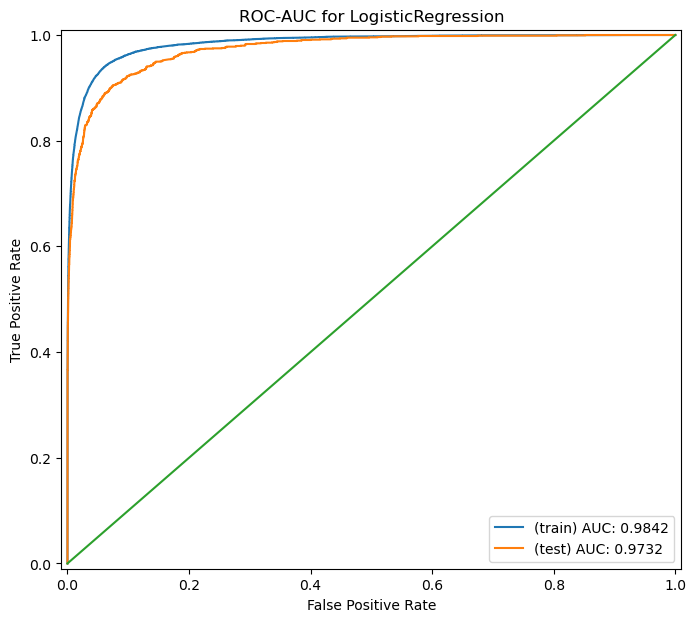

(train) ROC-AUC: 0.9841533825125761
(test) ROC-AUC: 0.9731526701676458


In [279]:
roc_train, roc_test = roc_auc(test_model, features_train, features_test, target_train, target_test, plot=True)

print(f'(train) ROC-AUC: {roc_train}')
print(f'(test) ROC-AUC: {roc_test}')

## Итоговый вывод

- Для предприятия «Викишоп» была обучена и представлена модель, способная к автоматической классификации комментариев на позитивные и негативные. 
- В результате по критерию качества предсказания (`(train CV) F1`); была сведена итоговая таблица с результатами обученных на кросс-валидации моделей:

In [280]:
training_stats

,(train CV) F1
Модель,
Логистическая регрессия,0.805
LightGBM,0.787
CatBoost,0.782
SGD,0.763


[CV 4/5] END ...C=106, max_iter=157, penalty=l2;, score=0.803 total time=   2.7s
[CV 5/5] END ...C=106, max_iter=157, penalty=l2;, score=0.812 total time=   3.0s
[CV 1/5] END ...C=106, max_iter=160, penalty=l2;, score=0.795 total time=   3.2s
[CV 1/5] END ...C=107, max_iter=157, penalty=l2;, score=0.797 total time=   3.1s
[CV 5/5] END ...C=107, max_iter=157, penalty=l2;, score=0.812 total time=   2.8s
[CV 4/5] END ...C=107, max_iter=159, penalty=l2;, score=0.805 total time=   3.1s
[CV 3/5] END ...C=107, max_iter=160, penalty=l2;, score=0.813 total time=   2.7s
[CV 2/5] END ...C=110, max_iter=157, penalty=l2;, score=0.799 total time=   2.7s
[CV 1/5] END ...C=110, max_iter=159, penalty=l2;, score=0.799 total time=   3.3s
[CV 5/5] END ...C=110, max_iter=159, penalty=l2;, score=0.811 total time=   2.7s
[CV 4/5] END ...C=110, max_iter=160, penalty=l2;, score=0.806 total time=   2.4s
[CV 3/5] END alpha=1.5e-06, eta0=0.004, learning_rate=adaptive, loss=modified_huber, max_iter=80, n_iter_no_c

- Лучшей моделью по метрике F1 оказалась:

In [110]:
best_model

'Логистическая регрессия'

- На тестовых данных она показала результат:

In [251]:
f'{final_test_f1:.3f} по метрике F1'

'0.772 по метрике F1'

Так как показатель удовлетворяют установленному критерию ($F_1 \ge 0.75$), данную модель следует рекомендовать заказчику.

- Можно заключить, что в рамках данного исследования удалось достичь показателя качества, установленного клиентом. Построенная модель способна предсказывать тональность комментариев с качеством по метрике F1 меры не менее 0.75, таким образом цель исследования достигнута.